In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
# Seed RNG (for reproducibility)
seed = 100
np.random.seed(seed)

In [47]:
# Sample from AR(1) process.
def sample_ar_1(alpha, sigma, T):
    ''' Sample T steps from an AR(1) process with noise variance sigma and ar-coefficient alpha'''
    noise = np.random.normal(0, sigma, T+1)
    X = np.zeros(T)

    for n in range(1,T):
        X[n] = (alpha*X[n-1]) + noise[n]
    return X

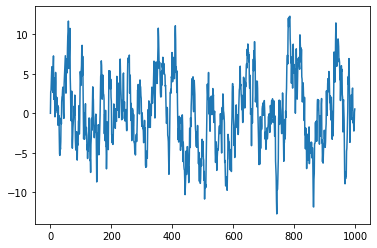

In [52]:
# Visualisation of the AR(1)
X = sample_ar_1(0.9, 2, 1000)
plt.plot(X)

In [108]:
# The goal is to train NN to predict the next value given the current value
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
import sklearn.metrics
import time

class ARModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [89]:
def loss_function(pred_y, y):
    return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    
def compute_loss(model, x, y, loss_fn=loss_function):
    preds = model.forward(x)
    mse = loss_fn(preds, y)
    return mse, preds


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss


def train_model(dataset, epochs=1, lr=0.001, log_steps=1000):
    model = ARModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, x in enumerate(dataset): # dataset will be vector of time-series here
            loss = train_batch(x[:-1,None], x[1:,None], model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss Vs Time steps')
        plt.show()
    return model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



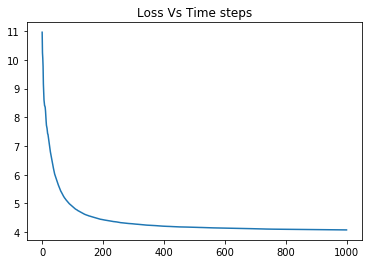

In [94]:
train_dataset = [sample_ar_1(0.8, 2, 1000) for i in range(1000)]
model = train_model(train_dataset)

99 99 99


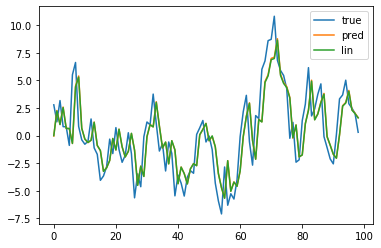

In [133]:
x = sample_ar_1(0.8, 2, 100)
y = model.forward(tf.convert_to_tensor(x[:,None]))

lin = np.zeros(len(x))
lin[0] = x[0]
for i in range(len(x)-1):
    lin[i+1] = 0.8*x[i]

print(len(x[1:]), len(y[:-1]), len(lin[1:]))
plt.plot(x[1:], label='true')
plt.plot(y[:-1], label='pred')
plt.plot(lin[1:], label='lin')
plt.legend()


In [134]:
print(sklearn.metrics.r2_score(x[1:], y[:-1]))
print(sklearn.metrics.r2_score(x[1:], lin[1:]))


0.6163322165850659
0.6166170593528592
